In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hyper Parameters
args = {
    'epochs': 10,
    'batch_size': 64,
    'lr_G': 0.0001,
    'lr_D': 0.0001,
    'num_ideas': 5,
    'art_components': 15,
}

In [3]:
PAINT_POINTS = np.vstack([np.linspace(-1, 1, args['art_components']) for _ in range(args['batch_size'])])
PAINT_POINTS.shape

(64, 15)

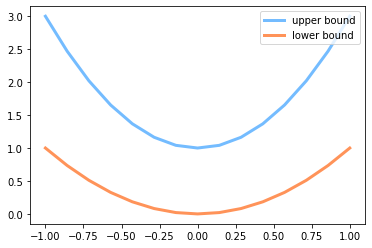

In [4]:
# show the painting range
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()

In [5]:
 # painting from the real artist (real target)
def artist_works_with_labels():
    a = np.random.uniform(1, 2, size=args['batch_size'])[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a - 1)
    labels = (a - 1) > 0.5         # upper paintings (1), lower paintings (0), two classes
    paintings = torch.from_numpy(paintings).float()
    labels = torch.from_numpy(labels.astype(np.float32))
    return paintings, labels

In [6]:
G = nn.Sequential(
    nn.Linear(args['num_ideas'] + 1, 128),
    nn.ReLU(),
    nn.Linear(128, args['art_components']),
)

D = nn.Sequential(
    nn.Linear(args['art_components'] + 1, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),
)

In [7]:
opt_G = torch.optim.Adam(G.parameters(), lr=args['lr_G'])
opt_D = torch.optim.Adam(D.parameters(), lr=args['lr_D'])

In [8]:
plt.ion()

0


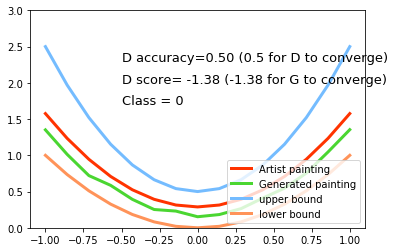

50


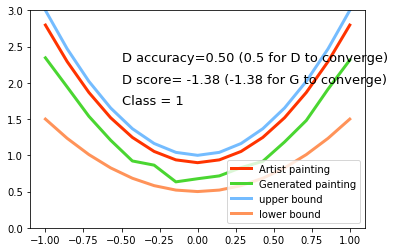

100


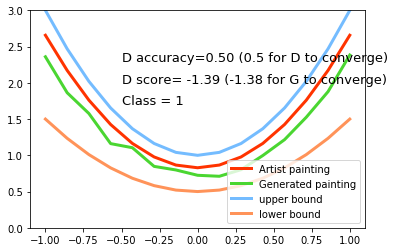

150


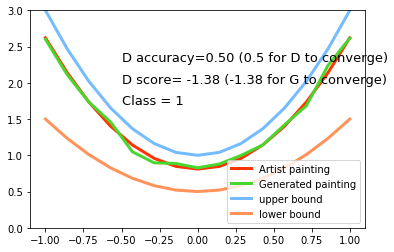

200


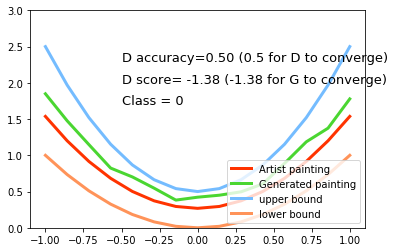

250


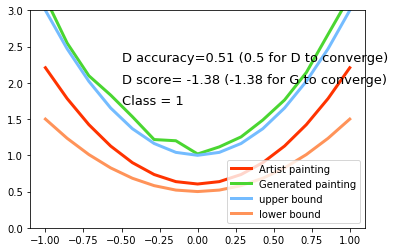

300


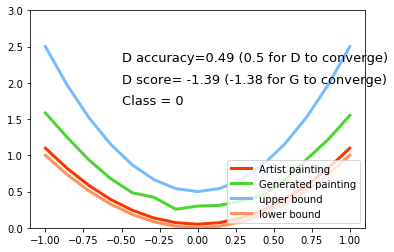

350


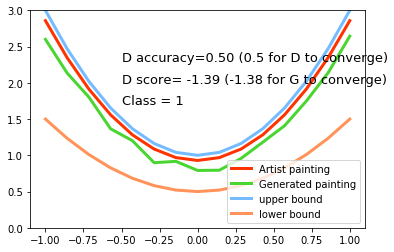

400


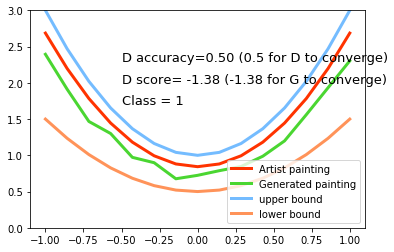

450


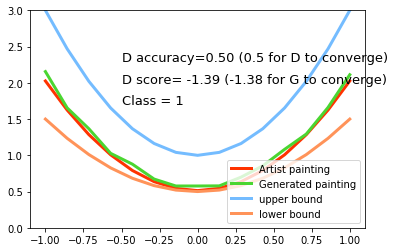

500


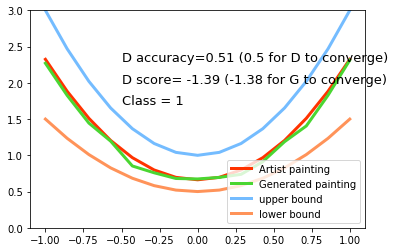

550


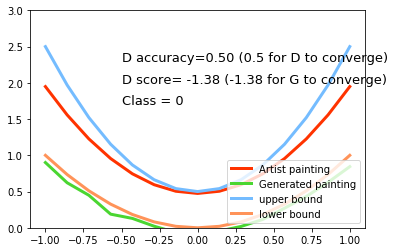

600


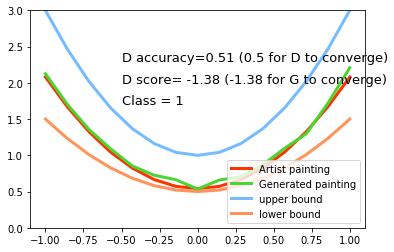

650


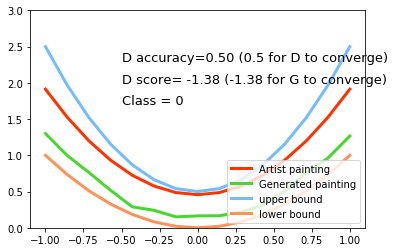

700


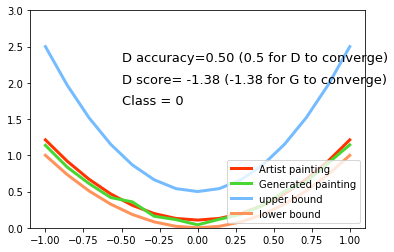

750


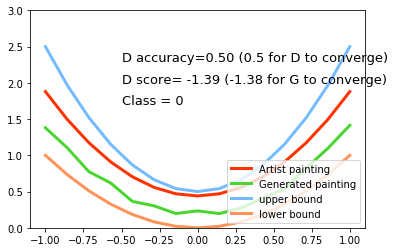

800


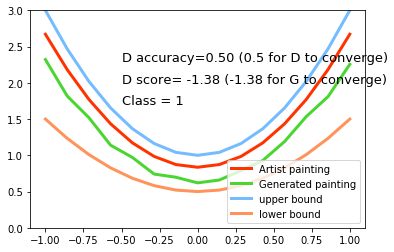

850


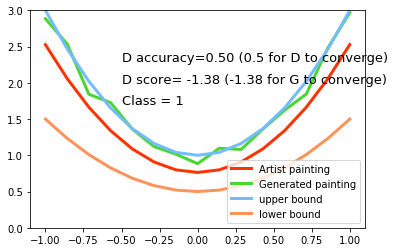

900


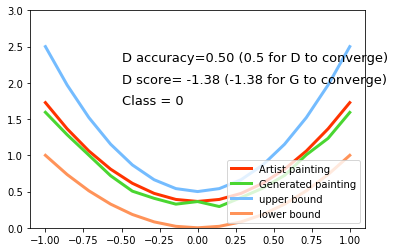

950


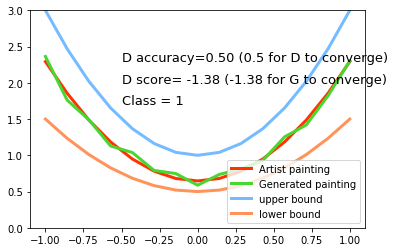

1000


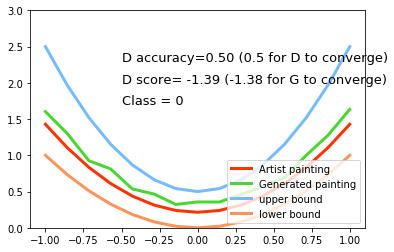

1050


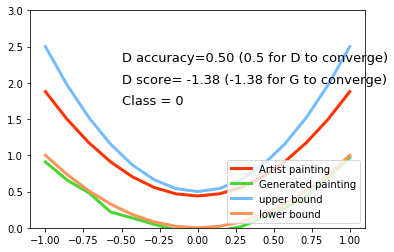

1100


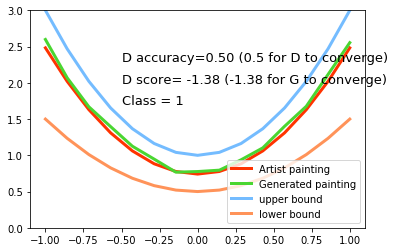

1150


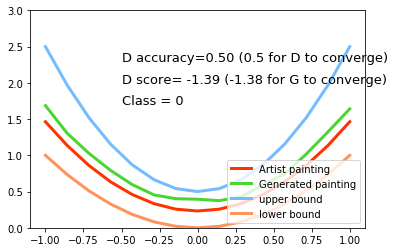

1200


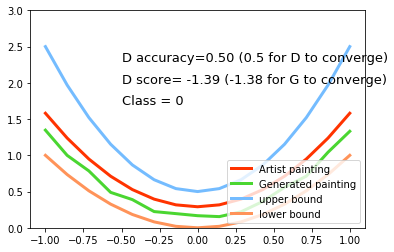

1250


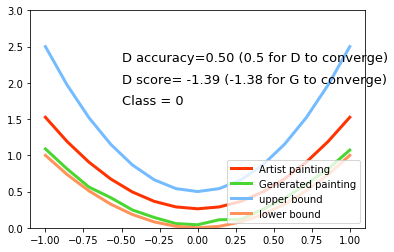

1300


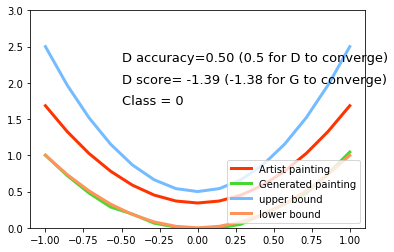

1350


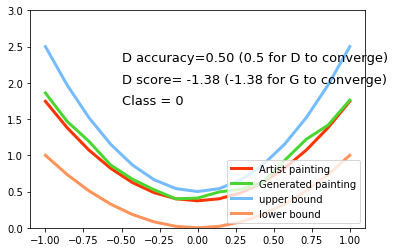

1400


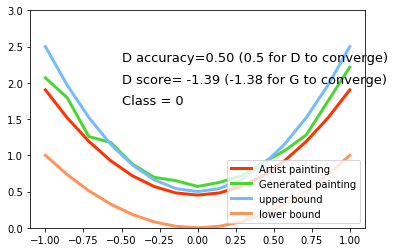

1450


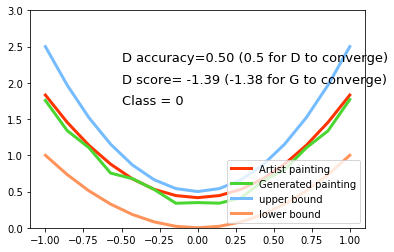

1500


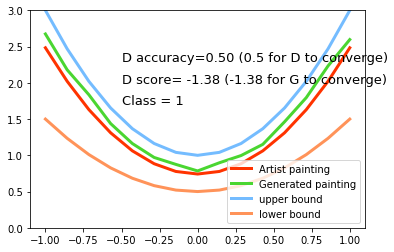

1550


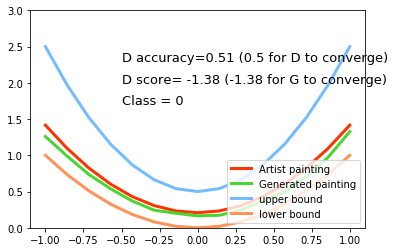

1600


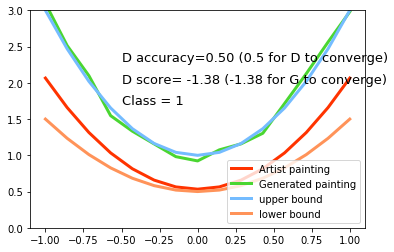

1650


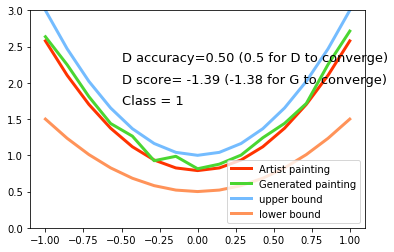

1700


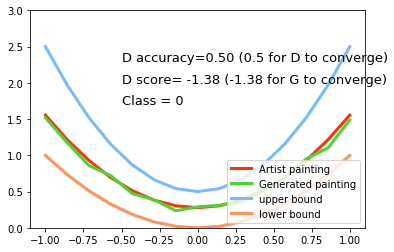

1750


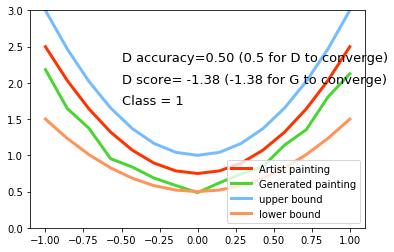

1800


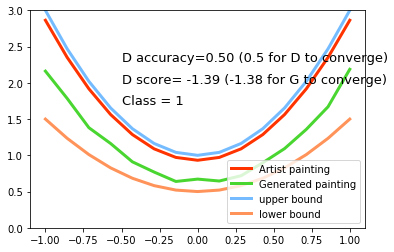

1850


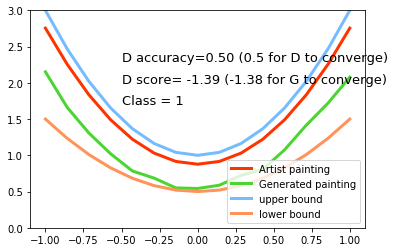

1900


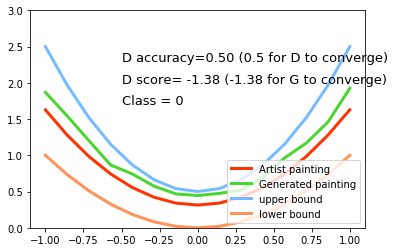

1950


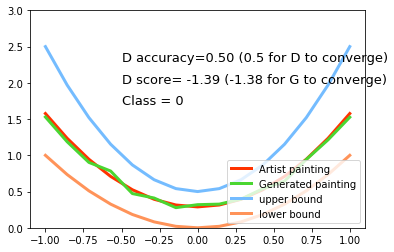

2000


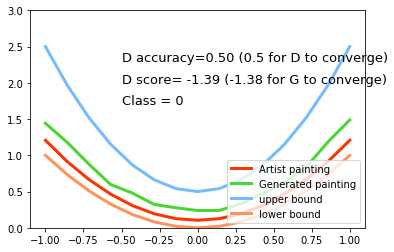

2050


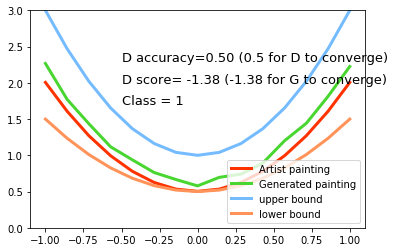

2100


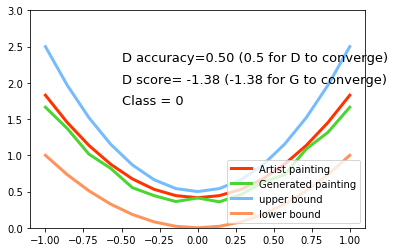

2150


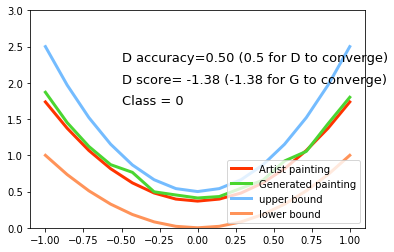

2200


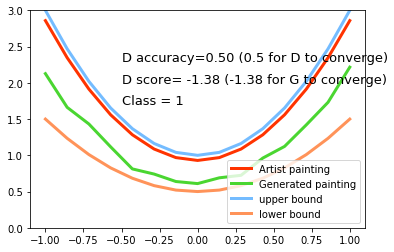

2250


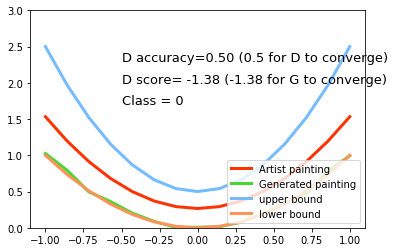

2300


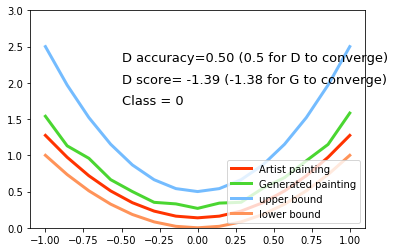

2350


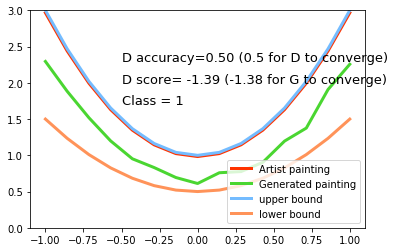

2400


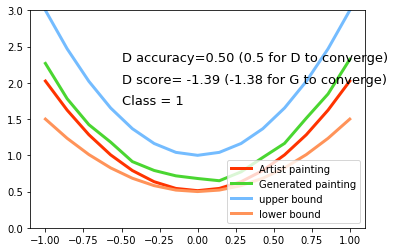

2450


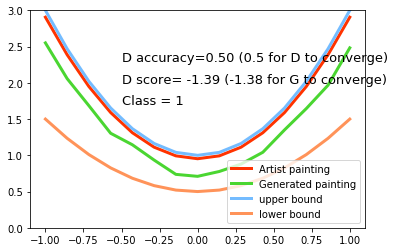

2500


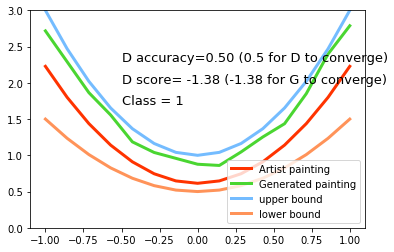

2550


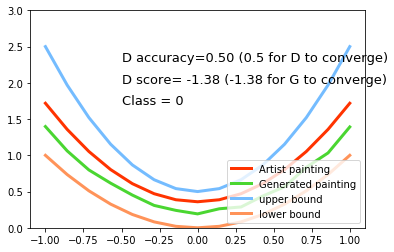

2600


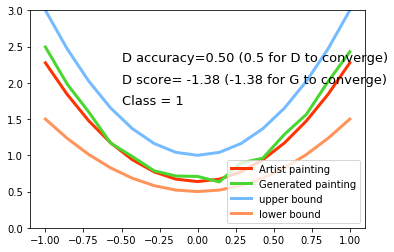

2650


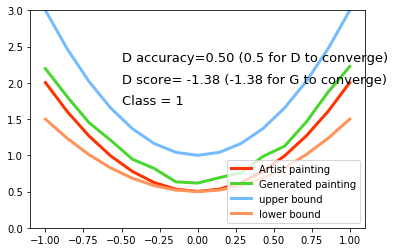

2700


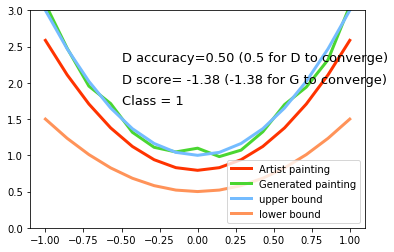

2750


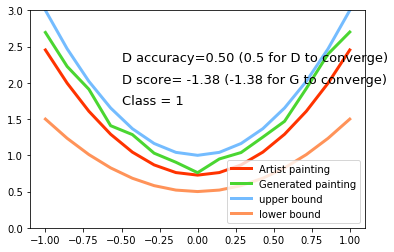

2800


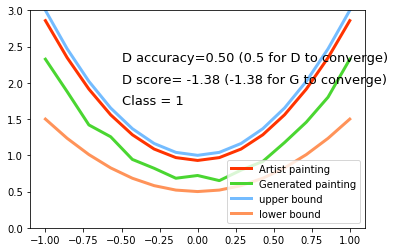

2850


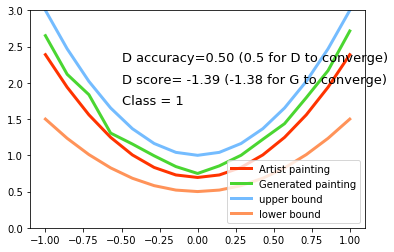

2900


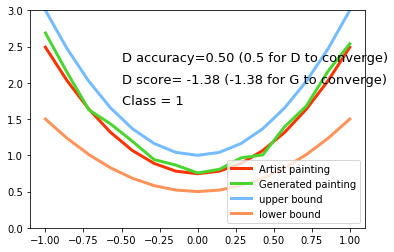

2950


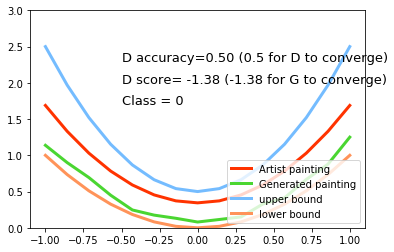

3000


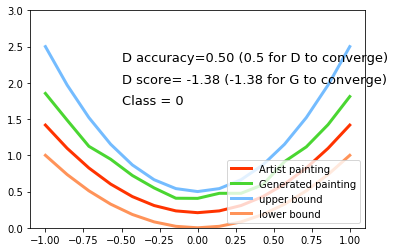

3050


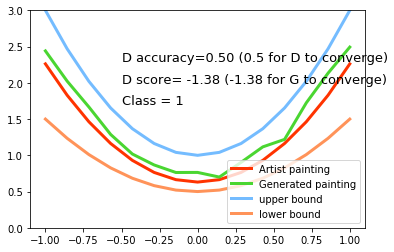

3100


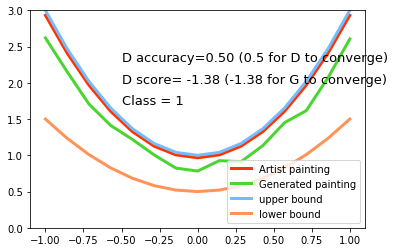

3150


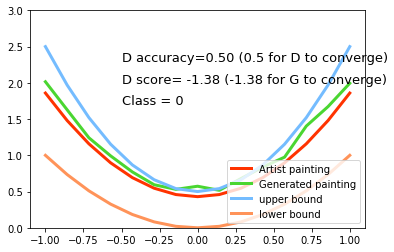

3200


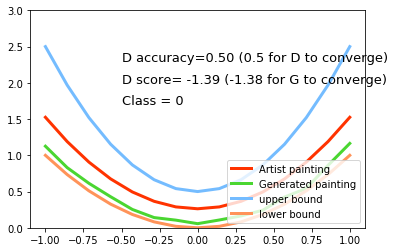

3250


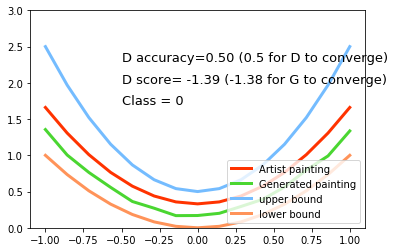

3300


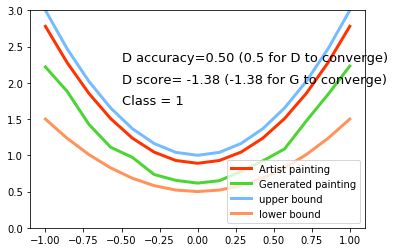

3350


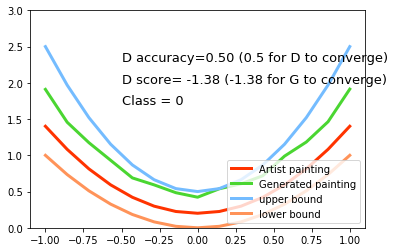

3400


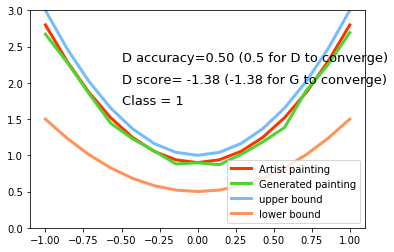

3450


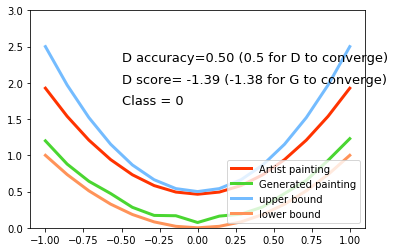

3500


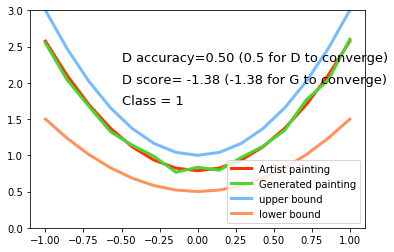

3550


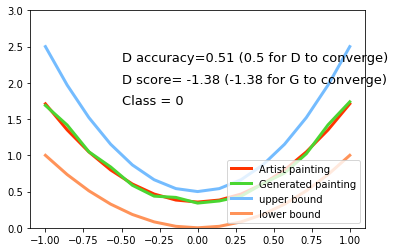

3600


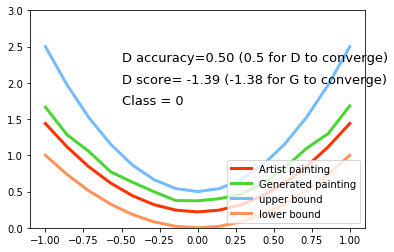

3650


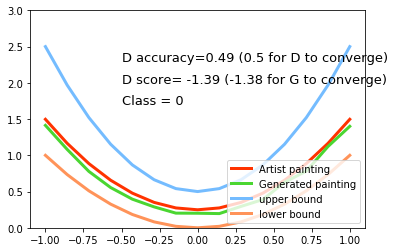

3700


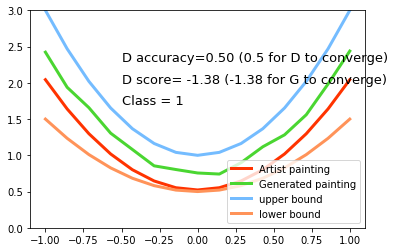

3750


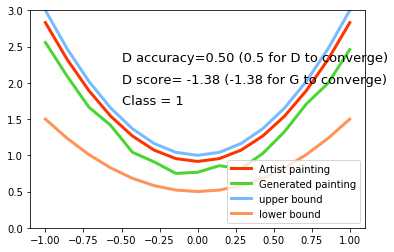

3800


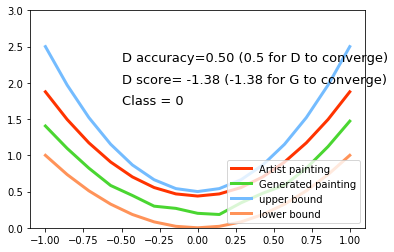

3850


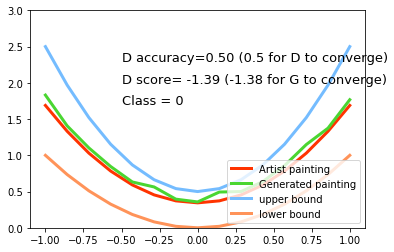

3900


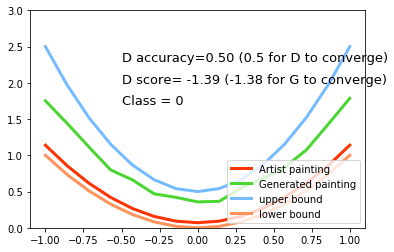

3950


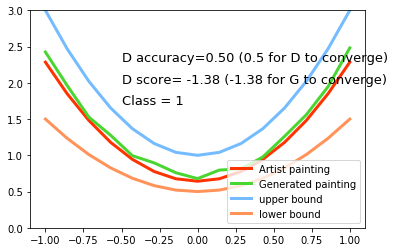

4000


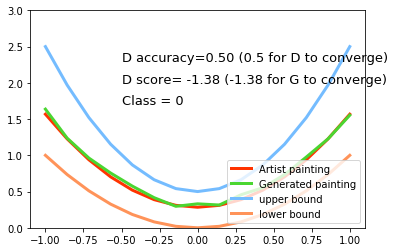

4050


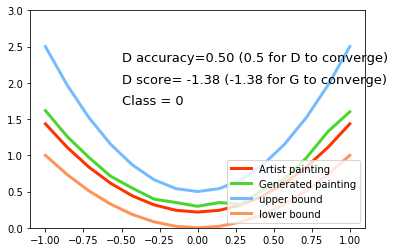

4100


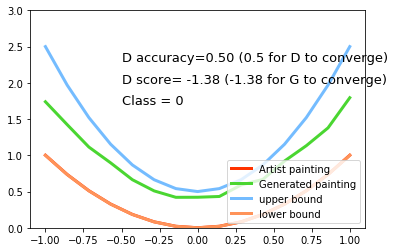

4150


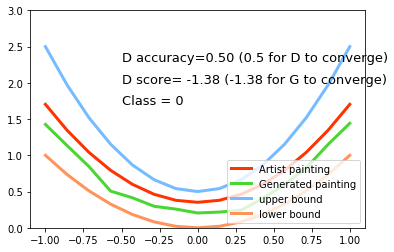

4200


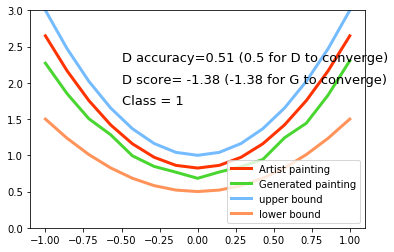

4250


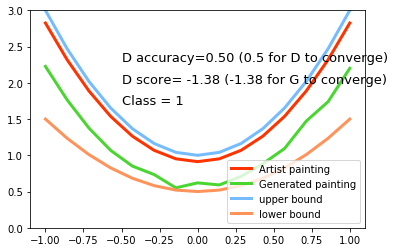

4300


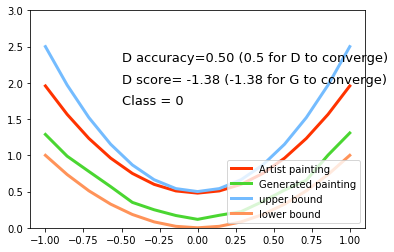

4350


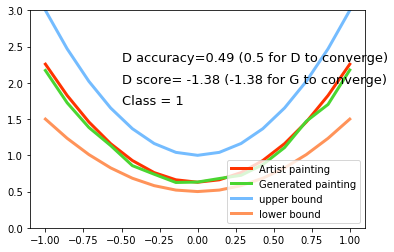

4400


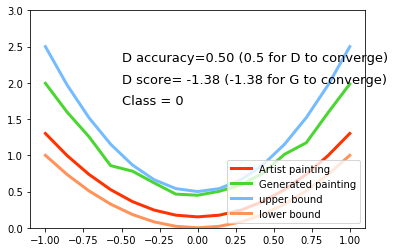

4450


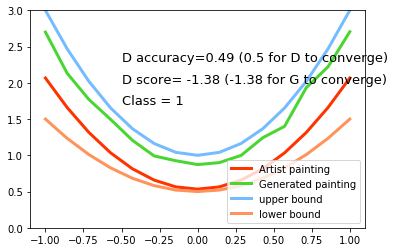

4500


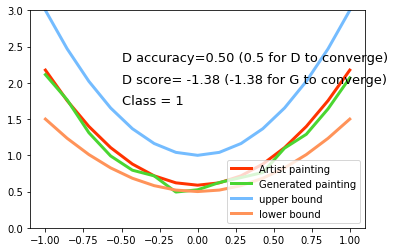

4550


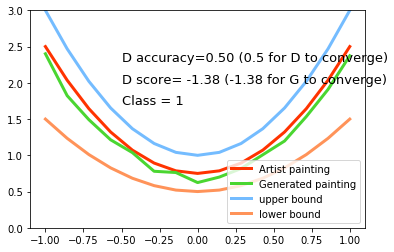

4600


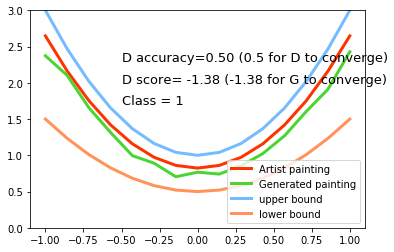

4650


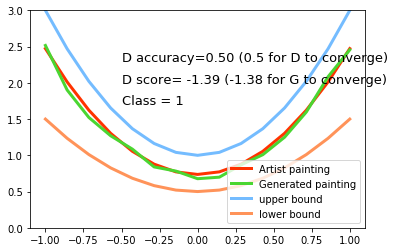

4700


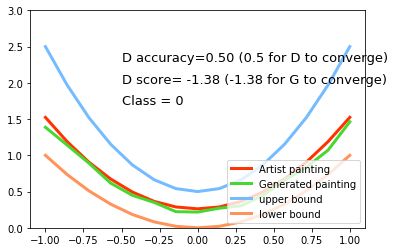

4750


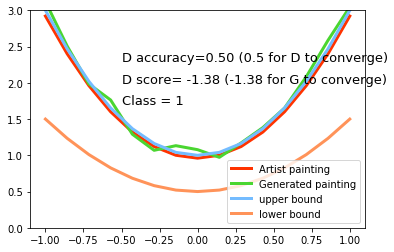

4800


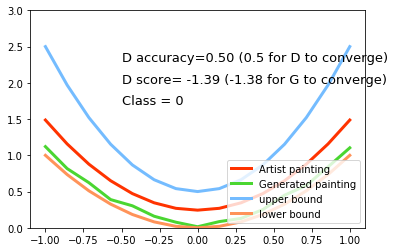

4850


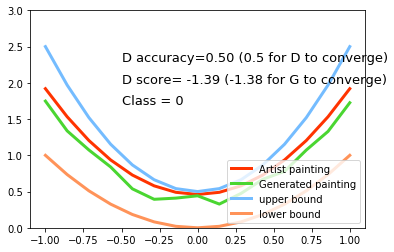

4900


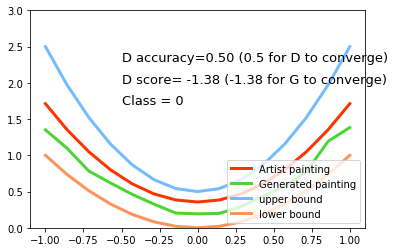

4950


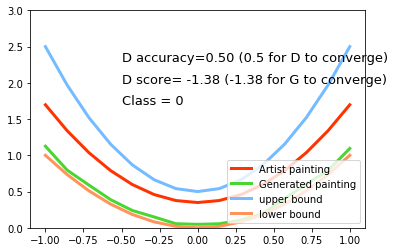

5000


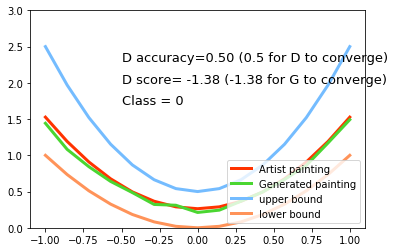

5050


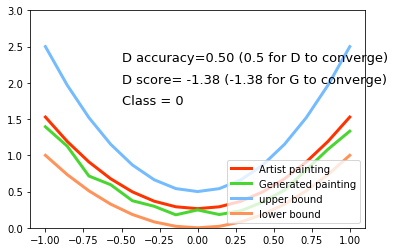

5100


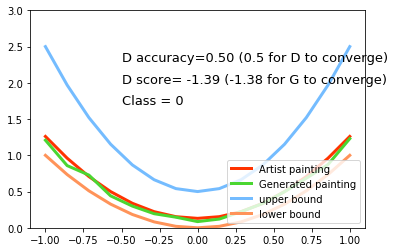

5150


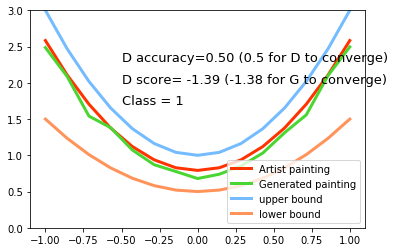

5200


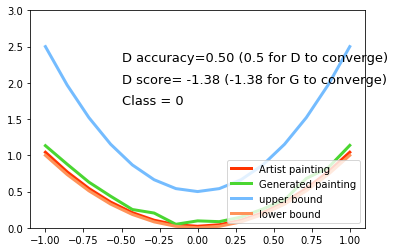

5250


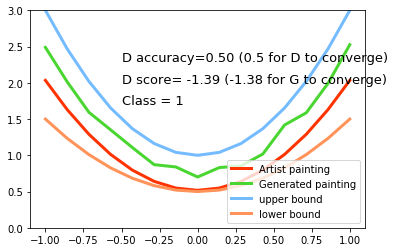

5300


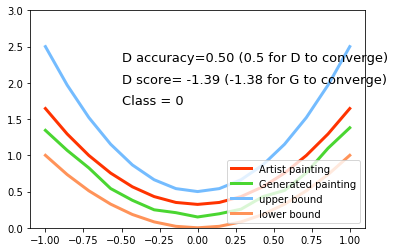

5350


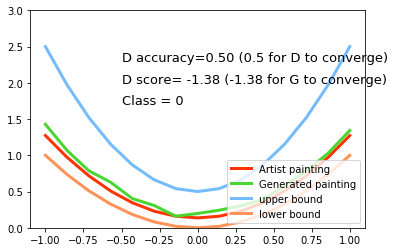

5400


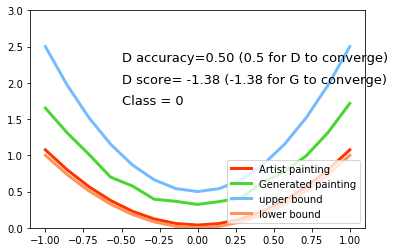

5450


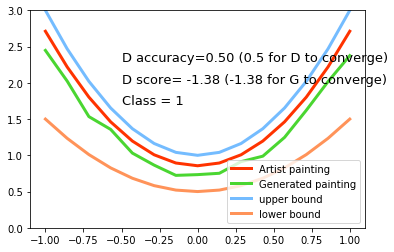

5500


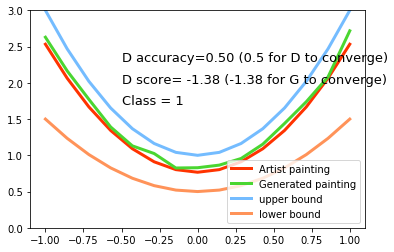

5550


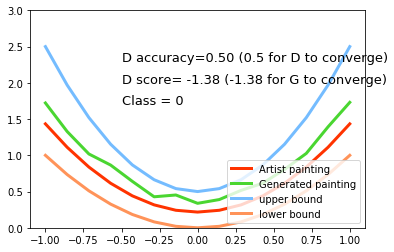

5600


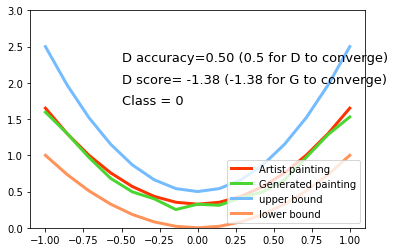

5650


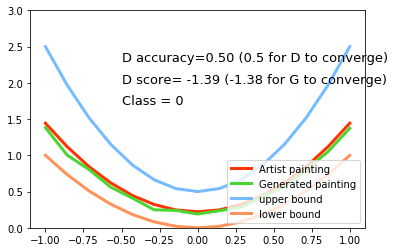

5700


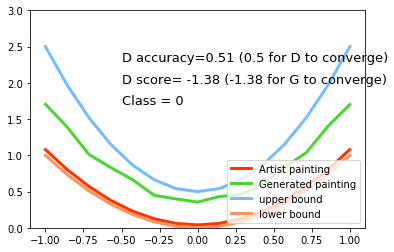

5750


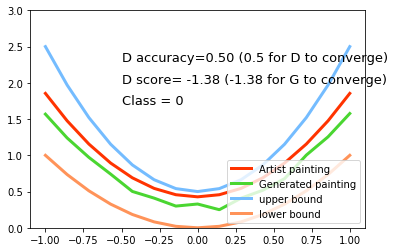

5800


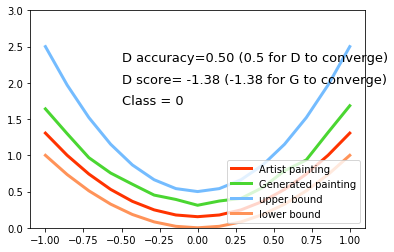

5850


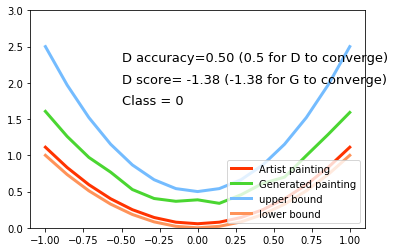

5900


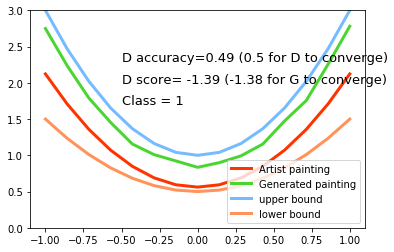

5950


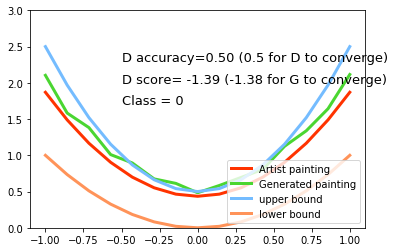

6000


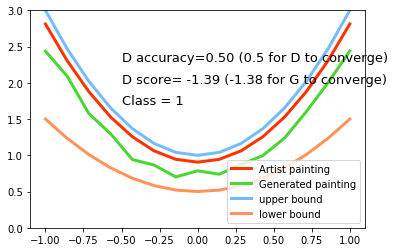

6050


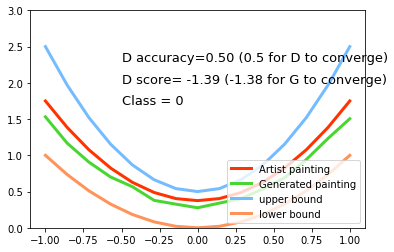

6100


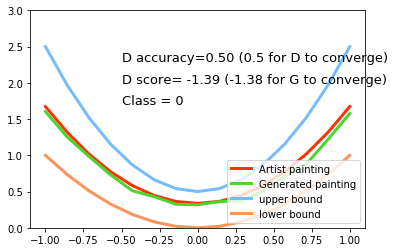

6150


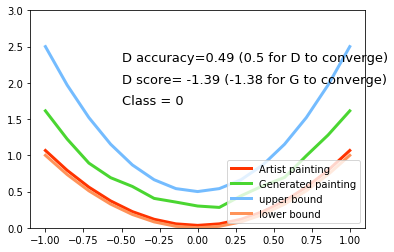

6200


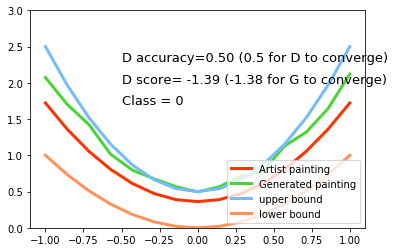

6250


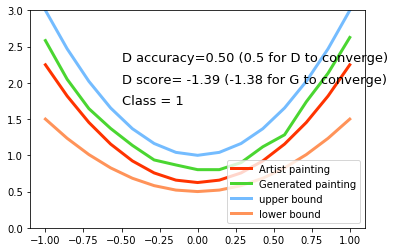

6300


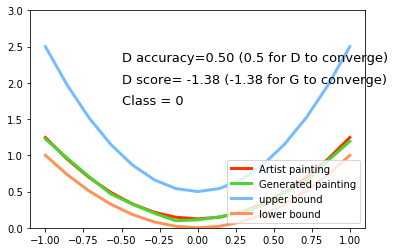

6350


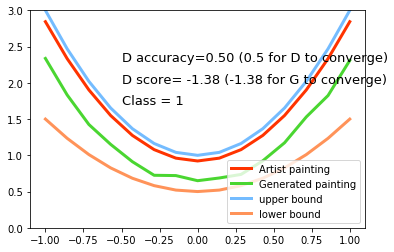

6400


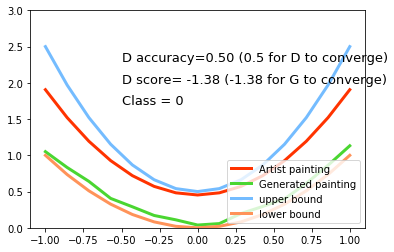

6450


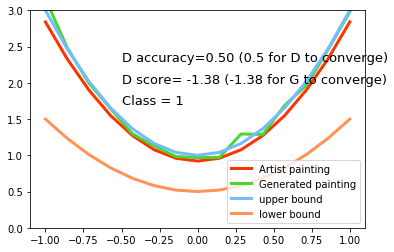

6500


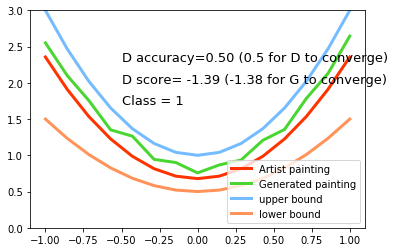

6550


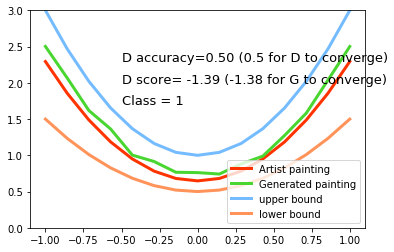

6600


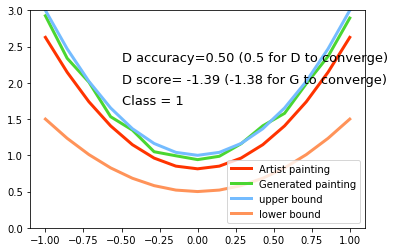

6650


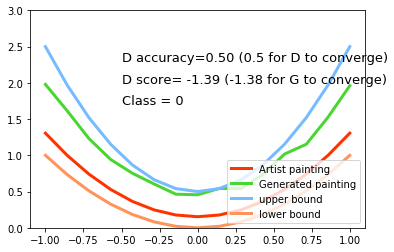

6700


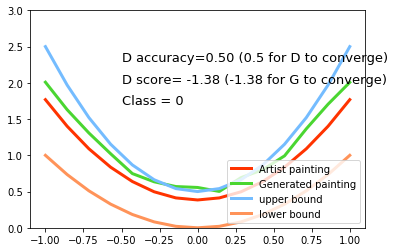

6750


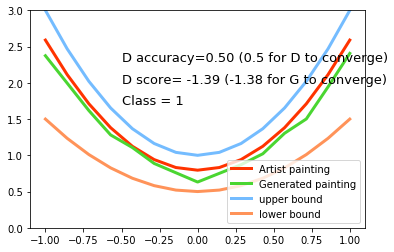

6800


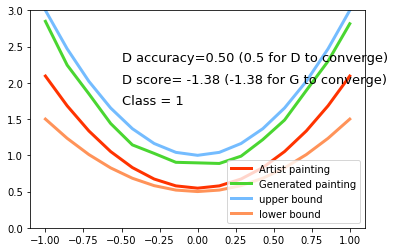

6850


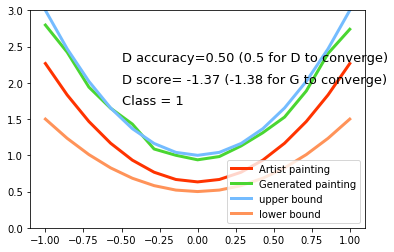

6900


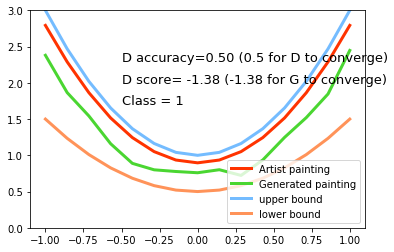

6950


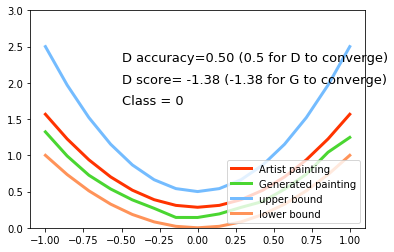

7000


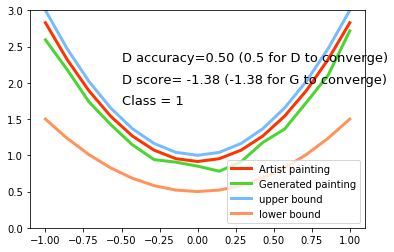

7050


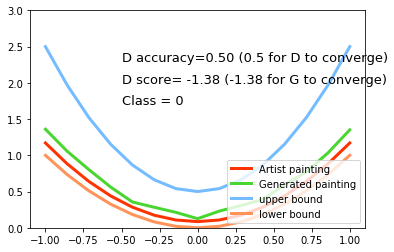

7100


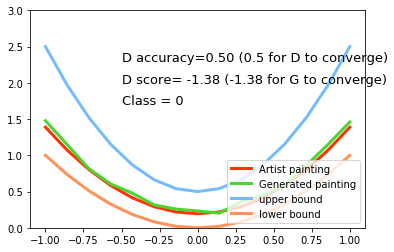

7150


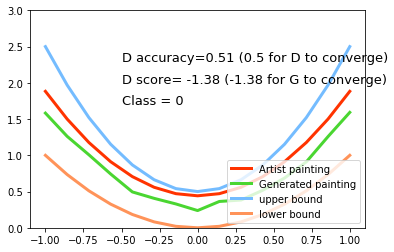

7200


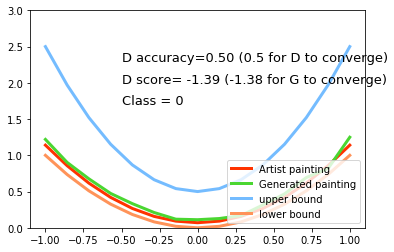

7250


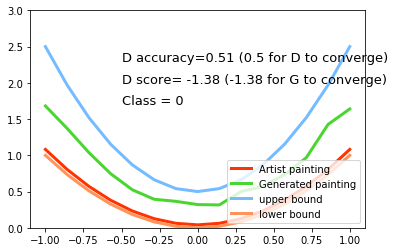

7300


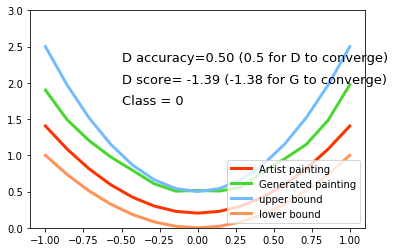

7350


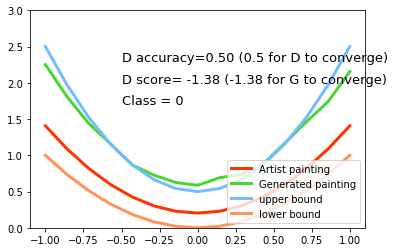

7400


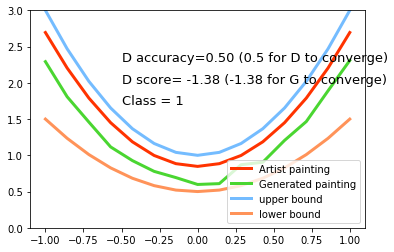

7450


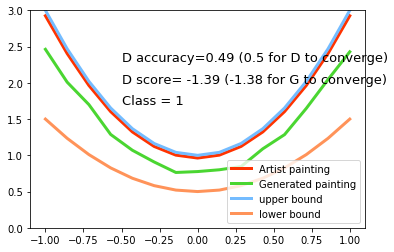

7500


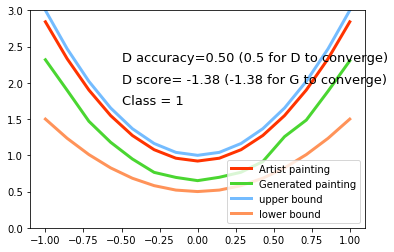

7550


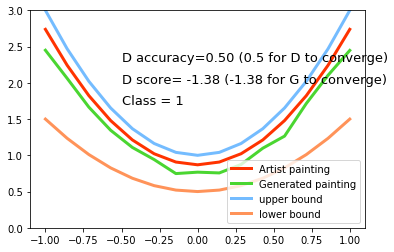

7600


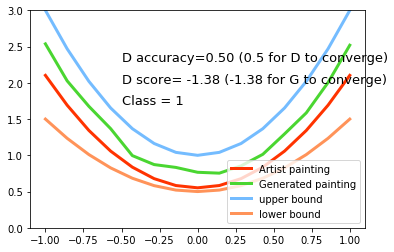

7650


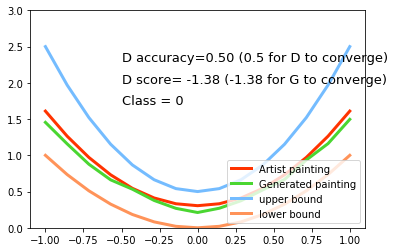

7700


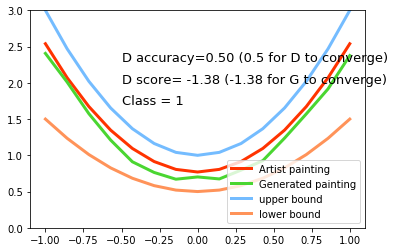

7750


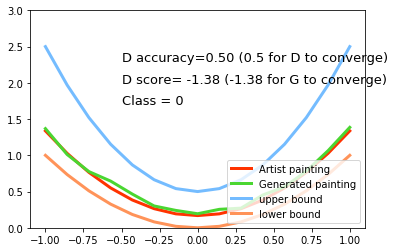

7800


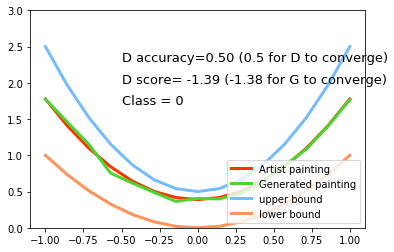

7850


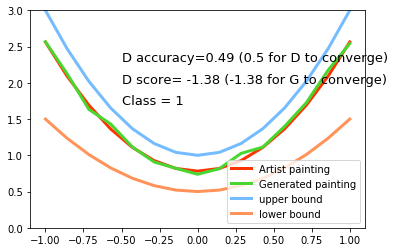

7900


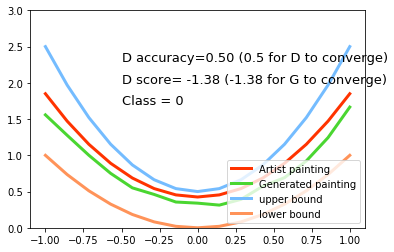

7950


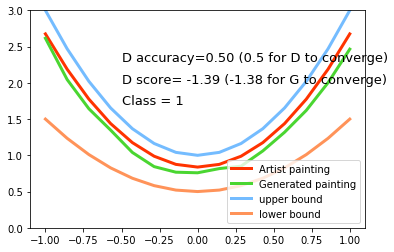

8000


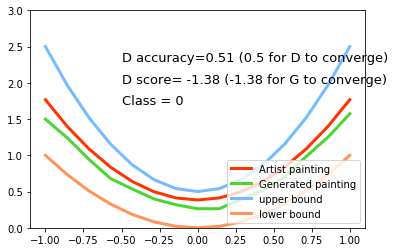

8050


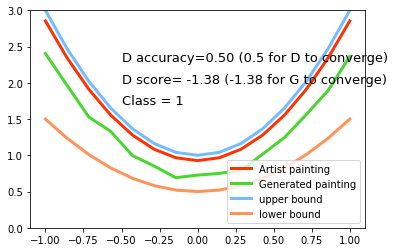

8100


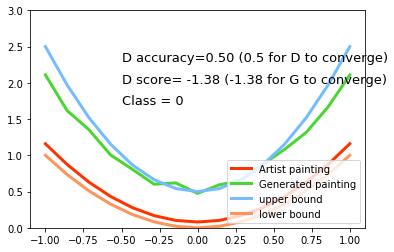

8150


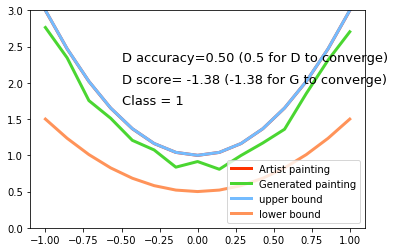

8200


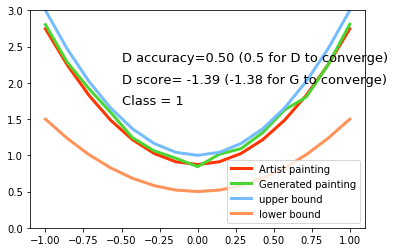

8250


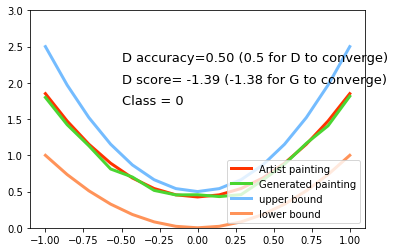

8300


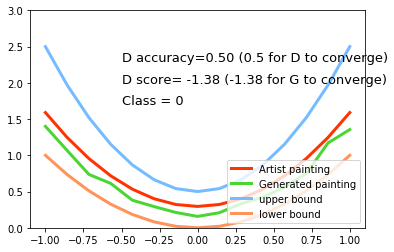

8350


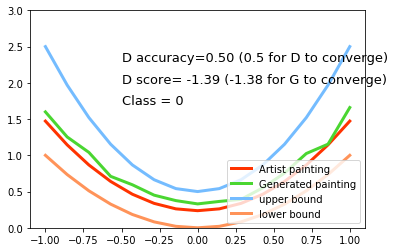

8400


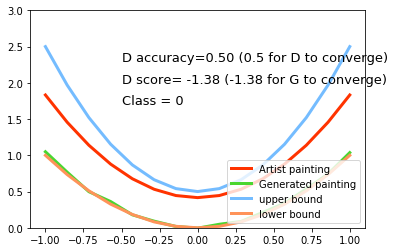

8450


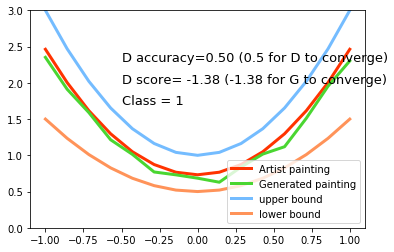

8500


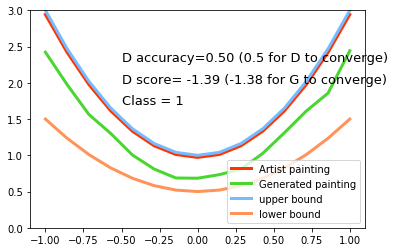

8550


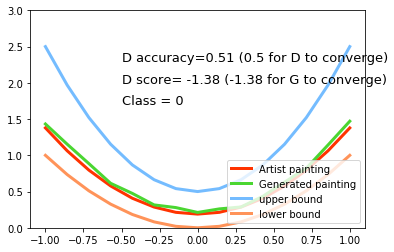

8600


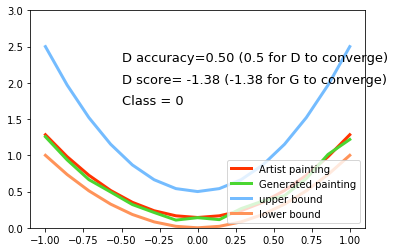

8650


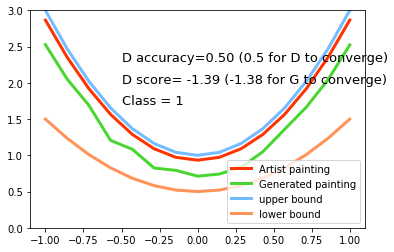

8700


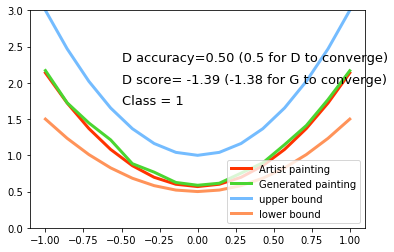

8750


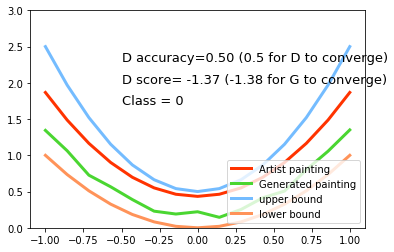

8800


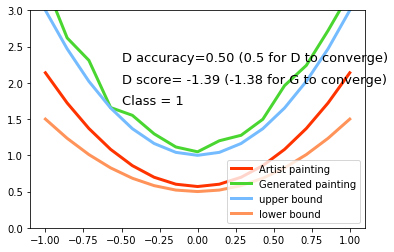

8850


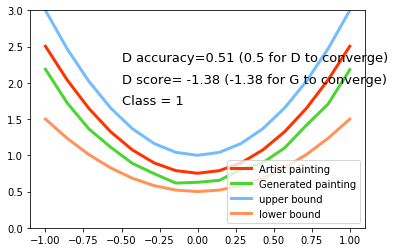

8900


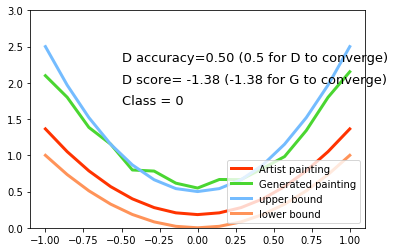

8950


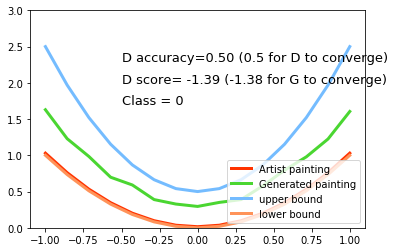

9000


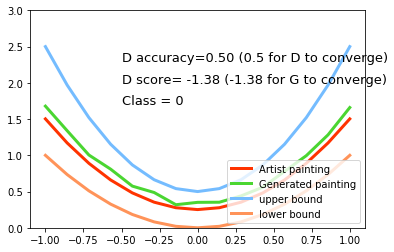

9050


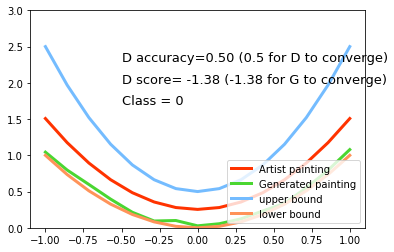

9100


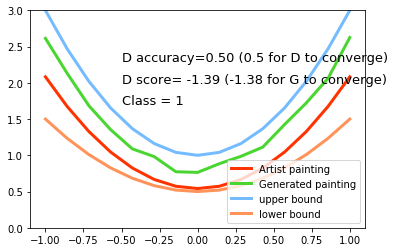

9150


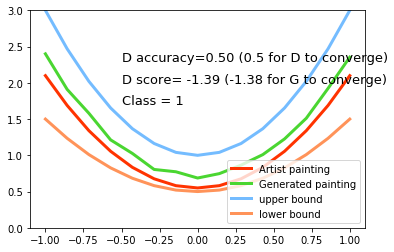

9200


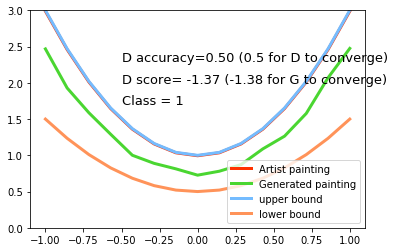

9250


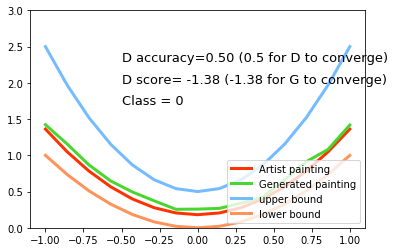

9300


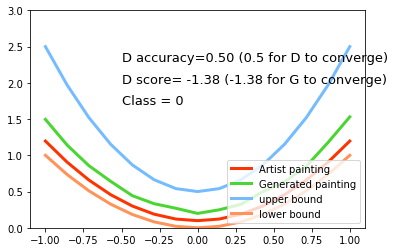

9350


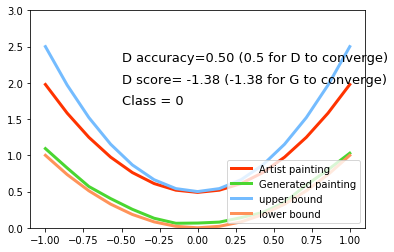

9400


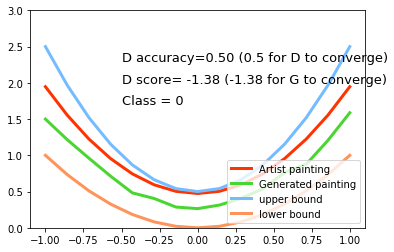

9450


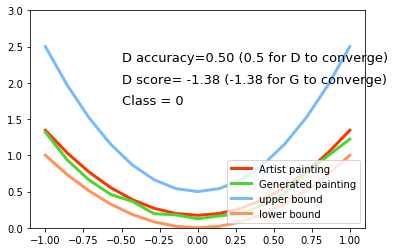

9500


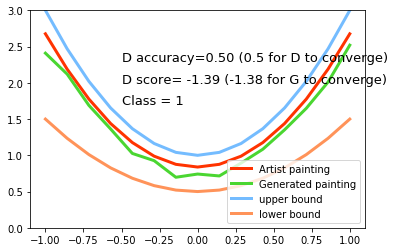

9550


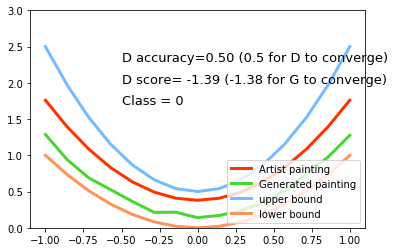

9600


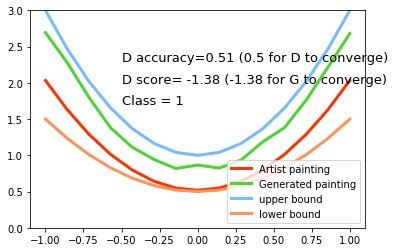

9650


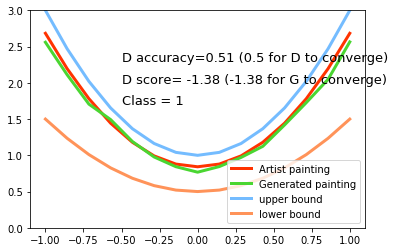

9700


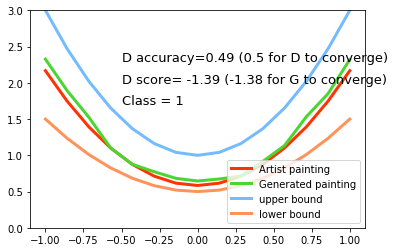

9750


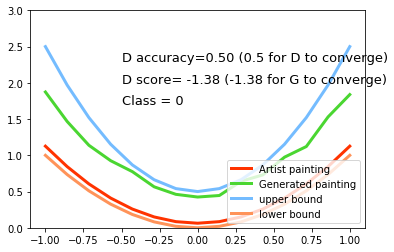

9800


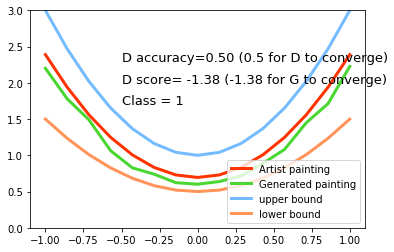

9850


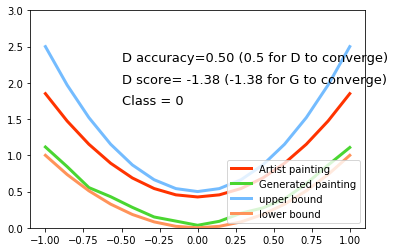

9900


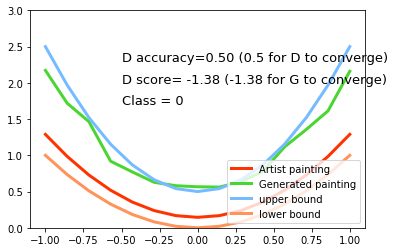

9950


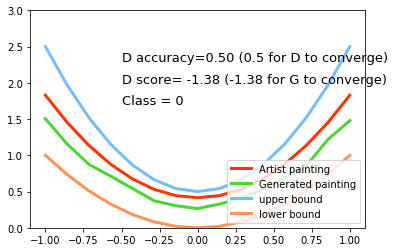

10000


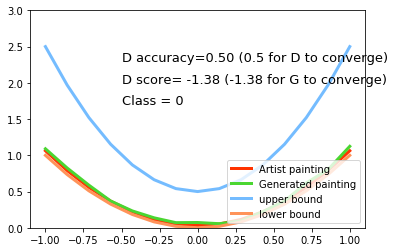

In [10]:
# train
for step in range(10001):
    artist_paintings, labels = artist_works_with_labels()                           # real painting, label from artist
    G_ideas = torch.randn(args['batch_size'], args['num_ideas'])          # random ideas
    G_inputs = torch.cat((G_ideas, labels), 1)                                             # ideas with labels
    G_paintings = G(G_inputs)                                                                       # fake painting w.r.t label from G

    D_inputs0 = torch.cat((artist_paintings, labels), 1)            # with labels
    D_inputs1 = torch.cat((G_paintings, labels), 1)
    prob_artist0 = D(D_inputs0)                 # to increase
    prob_artist1 = D(D_inputs1)                 # to reduce

    D_loss = -torch.mean(torch.log(prob_artist0) + torch.log(1. - prob_artist1))
#     G_loss = torch.mean(torch.log(1. - prob_artist1))
    G_loss = -torch.mean(torch.log(prob_artist1))
    
    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)   # reusing computational graph
    opt_D.step()
    
    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
    
    if step % 50 == 0:  # plotting
        print(step)
        plt.cla()
        plt.plot(PAINT_POINTS[0], artist_paintings.data.numpy()[0], c='#ff3300', lw=3, label='Artist painting',)
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        bound = [0, 0.5] if labels.data[0, 0] == 0 else [0.5, 1] 
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + bound[1], c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + bound[0], c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 13})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 13})
        plt.text(-.5, 1.7, 'Class = %i' % int(labels.data[0, 0]), fontdict={'size': 13})
        plt.ylim((0, 3))
        plt.legend(loc='lower right', fontsize=10)
        plt.draw()
        plt.pause(0.1)

plt.ioff()
plt.show()